#Titanic — Projeto de Machine Learning (Classificação)
**Autor:** 5MLET - Anderson, Beatriz, Marianna, Murilo, Welder.
**Objetivo:** Prever **sobrevivência** no Titanic a partir de variáveis demográficas e de ticket.  
**Tipo:** Classificação binária (0 = não sobreviveu, 1 = sobreviveu)

Este notebook segue um fluxo **completo**, incluindo:
1. Coleta / carregamento dos dados (Upload manual)
2. Análise Exploratória de Dados (EDA)
3. Pré-processamento (limpeza, imputação, codificação, escala)
4. Treinamento de modelos (Logistic Regression, Decision Tree, Random Forest)
5. Avaliação (Accuracy, Precision, Recall, F1, Matriz de Confusão)
6. Interpretação (importância de features / coeficientes)
7. Export do melhor modelo para uso posterior


## 1. Ambiente e Instalações
As bibliotecas principais serão instaladas abaixo.

In [28]:
!pip -q install numpy pandas scikit-learn matplotlib


In [29]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import sys, sklearn
import seaborn as sns
import gradio as gr
import joblib
import os
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold, cross_val_score


## 2. Carregar Dados

**Upload manual:**
  2.1 - Criar uma pasta com nome de "data" sem aspas
  2.2 - Fazer upload de `train.csv` e `test.csv` manualmente no Colab dentro da pasta data.

## 3. Inspeção Rápida

In [30]:
DATA_DIR = Path("data")
train_path = DATA_DIR / "train.csv"
test_path  = DATA_DIR / "test.csv"

assert train_path.exists(), "train.csv não encontrado em ./data"
assert test_path.exists(),  "test.csv não encontrado em ./data"

df = pd.read_csv(train_path)
print("Formato (linhas, colunas):", df.shape)
df.head(10)

Formato (linhas, colunas): (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [32]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Dooley, Mr. Patrick",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


## 4. Análise Exploratória (EDA)
Objetivo: entender variáveis, distribuições e possíveis relações com o alvo (`Survived`).

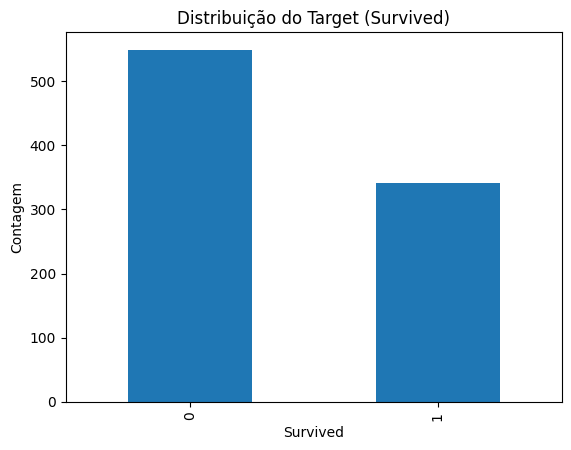

In [33]:
# Distribuição do target
plt.figure()
df["Survived"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição do Target (Survived)")
plt.xlabel("Survived")
plt.ylabel("Contagem")
plt.show()

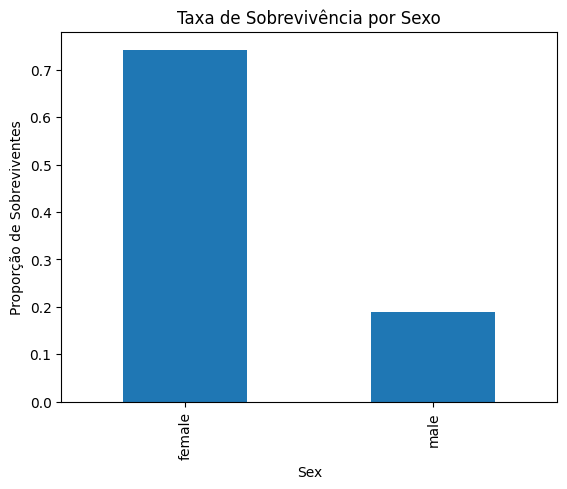

In [34]:
# Distribuição por Sexo
plt.figure()
df.groupby("Sex")["Survived"].mean().plot(kind="bar")
plt.title("Taxa de Sobrevivência por Sexo")
plt.ylabel("Proporção de Sobreviventes")
plt.show()

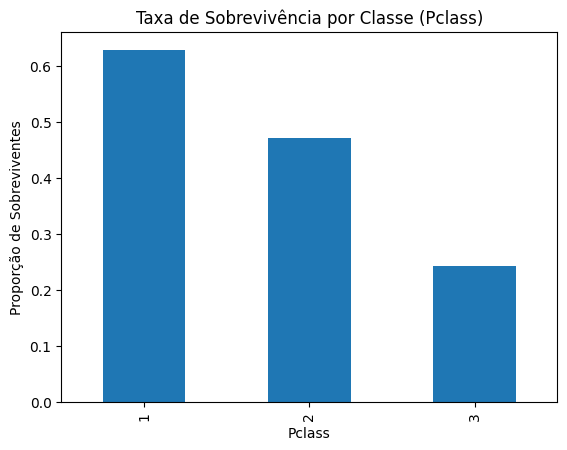

In [35]:
# Distribuição por Classe
plt.figure()
df.groupby("Pclass")["Survived"].mean().plot(kind="bar")
plt.title("Taxa de Sobrevivência por Classe (Pclass)")
plt.ylabel("Proporção de Sobreviventes")
plt.show()

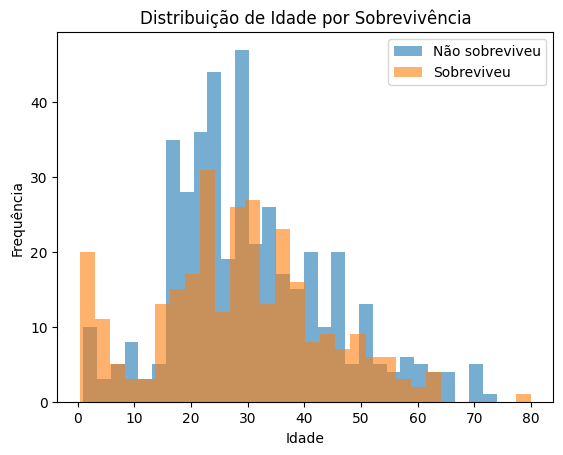

In [36]:
# Idade vs Sobrevivência (histogramas lado a lado por classe de sobrevivência)
plt.figure()
df[df["Survived"]==0]["Age"].dropna().plot(kind="hist", bins=30, alpha=0.6, label="Não sobreviveu")
df[df["Survived"]==1]["Age"].dropna().plot(kind="hist", bins=30, alpha=0.6, label="Sobreviveu")
plt.legend()
plt.title("Distribuição de Idade por Sobrevivência")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

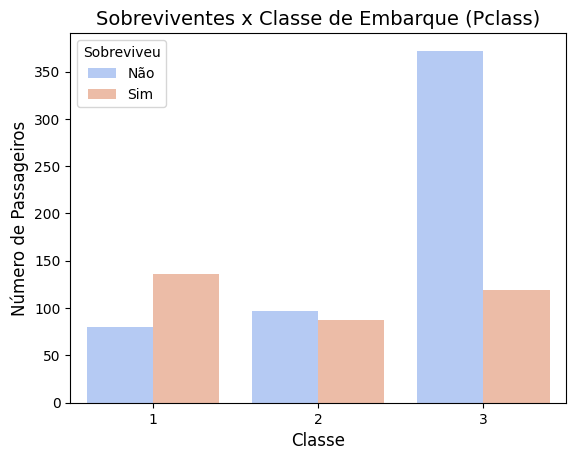

In [37]:
# Sobreviventes por Classe
plt.figure()
sns.countplot(x="Pclass", hue="Survived", data=df, palette="coolwarm")
plt.title("Sobreviventes x Classe de Embarque (Pclass)", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Número de Passageiros", fontsize=12)
plt.legend(title="Sobreviveu", labels=["Não", "Sim"], fontsize=10)
plt.show()

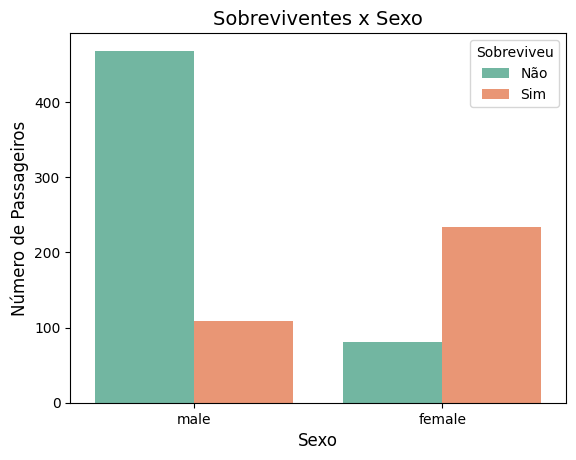

In [38]:
# Sobreviventes por Sexo
plt.figure()
sns.countplot(x="Sex", hue="Survived", data=df, palette="Set2")
plt.title("Sobreviventes x Sexo", fontsize=14)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Número de Passageiros", fontsize=12)
plt.legend(title="Sobreviveu", labels=["Não", "Sim"], fontsize=10)
plt.show()

In [39]:
# Cruzamento de Classe + Sexo + Sobrevivência
cross_tab = pd.crosstab([df['Pclass'], df['Sex']], df['Survived'], margins=True)
cross_tab.columns = ['Não Sobreviveu', 'Sobreviveu', 'Total']
print("\nTabela cruzada — Classe x Sexo x Sobrevivência:")
display(cross_tab)


Tabela cruzada — Classe x Sexo x Sobrevivência:


Não Sobreviveu  Sobreviveu  Total
Pclass Sex                                      
1      female               3          91     94
       male                77          45    122
2      female               6          70     76
       male                91          17    108
3      female              72          72    144
       male               300          47    347
All                       549         342    891

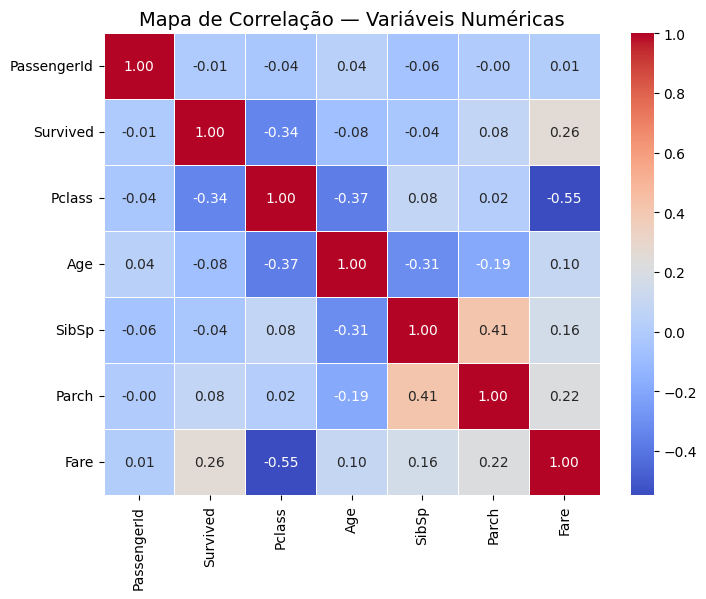

In [40]:
# Correlação numérica (Pearson)
plt.figure(figsize=(8,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Mapa de Correlação — Variáveis Numéricas", fontsize=14)
plt.show()

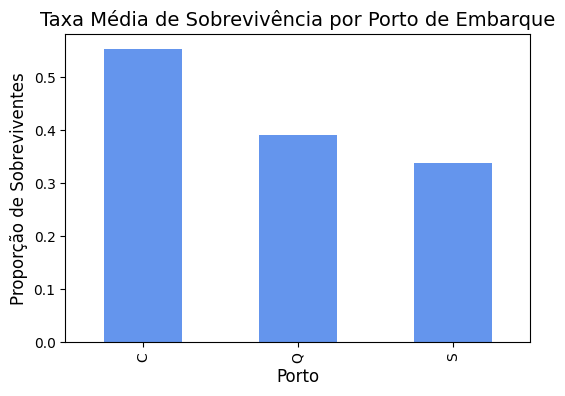

In [41]:
# Taxa de sobrevivência por Porto de Embarque
embarked_survival = df.groupby("Embarked")["Survived"].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
embarked_survival.plot(kind="bar", color="cornflowerblue")
plt.title("Taxa Média de Sobrevivência por Porto de Embarque", fontsize=14)
plt.ylabel("Proporção de Sobreviventes", fontsize=12)
plt.xlabel("Porto", fontsize=12)
plt.show()

/tmp/ipython-input-2118569413.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="FamilySize", y="Survived", data=df, palette="crest")


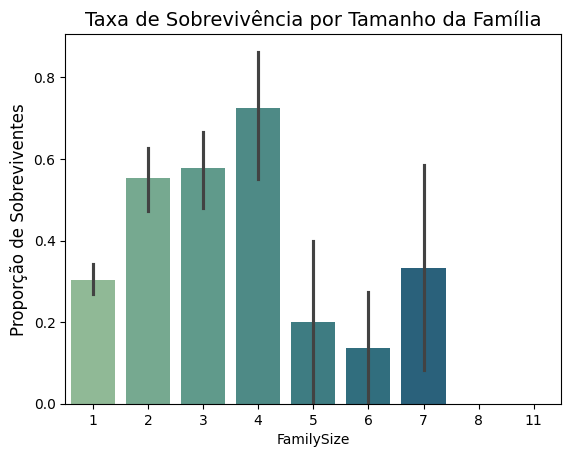

In [42]:
# Relação entre Tamanho da Família e Sobrevivência
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
plt.figure()
sns.barplot(x="FamilySize", y="Survived", data=df, palette="crest")
plt.title("Taxa de Sobrevivência por Tamanho da Família", fontsize=14)
plt.ylabel("Proporção de Sobreviventes", fontsize=12)
plt.show()

In [43]:
# Estatísticas descritivas resumidas
print("\nEstatísticas de sobrevivência:")
print("Taxa geral de sobrevivência: {:.2f}%".format(df['Survived'].mean()*100))
print("Homens sobreviventes: {:.2f}%".format(df[df['Sex']=='male']['Survived'].mean()*100))
print("Mulheres sobreviventes: {:.2f}%".format(df[df['Sex']=='female']['Survived'].mean()*100))
print("\nPor classe:")
print(df.groupby("Pclass")["Survived"].mean().apply(lambda x: f"{x*100:.2f}%"))


Estatísticas de sobrevivência:
Taxa geral de sobrevivência: 38.38%
Homens sobreviventes: 18.89%
Mulheres sobreviventes: 74.20%

Por classe:
Pclass
1    62.96%
2    47.28%
3    24.24%
Name: Survived, dtype: object


In [44]:
# Síntese automática de insights (EDA + resultado do modelo)
print("\n Síntese de Insights:")

# Análises qualitativas extraídas dos dados
gender_diff = df[df['Sex']=='female']['Survived'].mean() - df[df['Sex']=='male']['Survived'].mean()
class_best = df.groupby('Pclass')['Survived'].mean().idxmax()
class_worst = df.groupby('Pclass')['Survived'].mean().idxmin()
embark_best = df.groupby('Embarked')['Survived'].mean().idxmax()
family_optimal = df.groupby('FamilySize')['Survived'].mean().idxmax()

print(f" Mulheres tiveram taxa de sobrevivência {gender_diff*100:.1f}% maior que os homens.")
print(f" Passageiros da 1ª classe apresentaram a maior taxa de sobrevivência, enquanto os da {class_worst}ª classe foram os mais vulneráveis.")
print(f" O porto de embarque com melhor taxa de sobrevivência foi '{embark_best}'.")
print(f" Famílias de tamanho {family_optimal} tiveram, em média, as maiores chances de sobrevivência.")


 Síntese de Insights:
 Mulheres tiveram taxa de sobrevivência 55.3% maior que os homens.
 Passageiros da 1ª classe apresentaram a maior taxa de sobrevivência, enquanto os da 3ª classe foram os mais vulneráveis.
 O porto de embarque com melhor taxa de sobrevivência foi 'C'.
 Famílias de tamanho 4 tiveram, em média, as maiores chances de sobrevivência.


In [45]:
# Verificação de nulos
nulls = df.isnull().sum().sort_values(ascending=False)
print(nulls[nulls>0])

Cabin       687
Age         177
Embarked      2
dtype: int64


## 5. Pré-processamento e Split
- Remove colunas pouco informativas: `PassengerId`, `Name`, `Ticket`, `Cabin`
- Imputa valores faltantes
- Codifica categóricas
- Escala numéricas (para modelos baseados em distância/gradiente)

In [46]:
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

TARGET = "Survived"
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]

# Define features e target
X = df.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = df[TARGET]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "| X_test:", X_test.shape)
print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

X_train: (712, 8) | X_test: (179, 8)
Numéricas: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']
Categóricas: ['Sex', 'Embarked']


## 6. Modelagem — Três Modelos
Treinaremos **Logistic Regression**, **Decision Tree** e **Random Forest** usando *pipelines* para garantir um fluxo limpo.

In [48]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

pipelines = {name: Pipeline(steps=[("preprocess", preprocess), ("model", m)])
             for name, m in models.items()}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f" {name} treinado.")

 LogisticRegression treinado.
 DecisionTree treinado.
 RandomForest treinado.


## 7. Avaliação — Métricas & Matriz de Confusão
Usaremos **Accuracy**, **Precision**, **Recall**, **F1** e **Matriz de Confusão** no conjunto de **teste**.

=== LogisticRegression ===
              precision    recall  f1-score   support

           0     0.8099    0.8909    0.8485       110
           1     0.7931    0.6667    0.7244        69

    accuracy                         0.8045       179
   macro avg     0.8015    0.7788    0.7864       179
weighted avg     0.8034    0.8045    0.8007       179



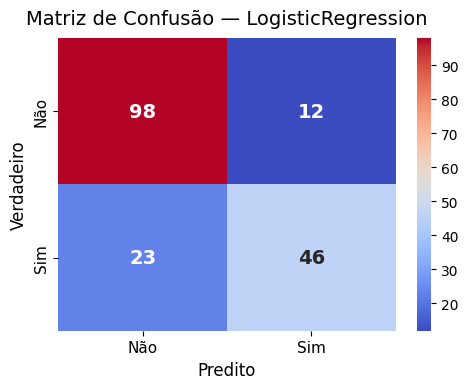

=== DecisionTree ===
              precision    recall  f1-score   support

           0     0.8125    0.8273    0.8198       110
           1     0.7164    0.6957    0.7059        69

    accuracy                         0.7765       179
   macro avg     0.7645    0.7615    0.7629       179
weighted avg     0.7755    0.7765    0.7759       179



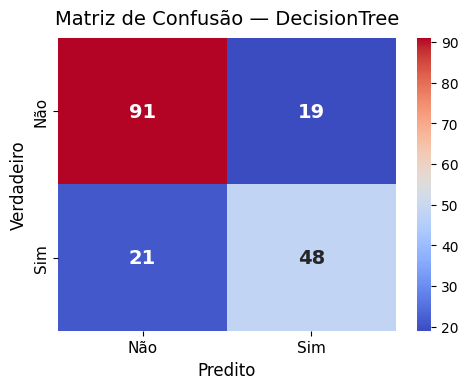

=== RandomForest ===
              precision    recall  f1-score   support

           0     0.8190    0.8636    0.8407       110
           1     0.7619    0.6957    0.7273        69

    accuracy                         0.7989       179
   macro avg     0.7904    0.7796    0.7840       179
weighted avg     0.7970    0.7989    0.7970       179



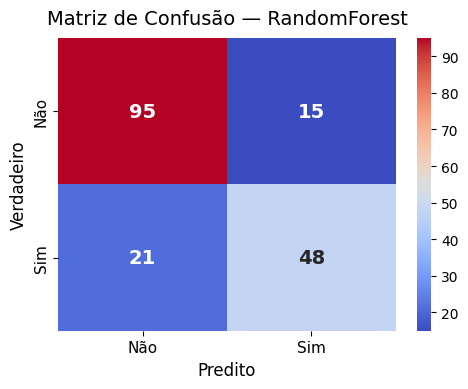

,model,accuracy,precision,recall,f1
0,RandomForest,0.799,0.762,0.696,0.727
1,LogisticRegression,0.804,0.793,0.667,0.724
2,DecisionTree,0.777,0.716,0.696,0.706


In [49]:
def evaluate_and_report(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))



    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='coolwarm',
        cbar=True,
        annot_kws={"size": 14, "weight": "bold"}
    )
    plt.title(f"Matriz de Confusão — {name}", fontsize=14, pad=10)
    plt.xlabel("Predito", fontsize=12)
    plt.ylabel("Verdadeiro", fontsize=12)
    plt.xticks([0.5, 1.5], ["Não", "Sim"], fontsize=11)
    plt.yticks([0.5, 1.5], ["Não", "Sim"], fontsize=11)
    plt.tight_layout()
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

results = []
for name, pipe in pipelines.items():
    res = evaluate_and_report(name, pipe, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
styled_results = results_df.style.background_gradient(cmap="Greens", subset=["accuracy","precision","recall","f1"]) \
                                   .set_caption("\nComparativo de Modelos") \
                                   .format({"accuracy":"{:.3f}","precision":"{:.3f}","recall":"{:.3f}","f1":"{:.3f}"})
styled_results

## 8. Validação Cruzada (opcional, recomendado)
Rodamos um K-Fold estratificado para avaliar estabilidade dos modelos.

In [50]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
    cv_scores[name] = {
        "f1_mean": scores.mean(),
        "f1_std": scores.std()
    }

pd.DataFrame(cv_scores).T.sort_values("f1_mean", ascending=False)

,f1_mean,f1_std
RandomForest,0.759421,0.027891
LogisticRegression,0.724233,0.023676
DecisionTree,0.701791,0.029409


## 9. Interpretabilidade — Importância/Coeficientes
- **RandomForest:** importância de features (após OneHot, usamos `get_feature_names_out`).
- **LogisticRegression:** coeficientes (sinal e magnitude).


In [51]:
set_config(transform_output="pandas")

# Reajusta pipeline para expor features após preprocess
best_name = results_df.iloc[0]["model"]
best_pipe = pipelines[best_name]

print(f"Melhor modelo (pelo F1 de teste): {best_name}")

# Ajusta no dataset completo para explicar melhor
best_pipe.fit(X, y)

# Extrai matriz transformada e nomes de colunas
pre = best_pipe.named_steps["preprocess"]
X_trans = pre.fit_transform(X)
feature_names = X_trans.columns

if best_name == "RandomForest":
    model = best_pipe.named_steps["model"]
    importances = model.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    fi.head(20)
elif best_name == "LogisticRegression":
    model = best_pipe.named_steps["model"]
    coefs = model.coef_[0]
    fi = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
    fi.head(20)
else:
    print("Interpretabilidade direta limitada para árvores simples sem ferramenta extra; use o RandomForest ou LogisticRegression para ranking de features.")

Melhor modelo (pelo F1 de teste): RandomForest


## 10. Exportar Modelo Treinado
Salvamos o **pipeline completo** (pré-processamento + modelo) com `joblib`. Assim, você pode carregar e usar diretamente.

In [56]:
os.makedirs("artifacts", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

best_name = results_df.iloc[0]["model"]
best_pipe = pipelines[best_name]
best_pipe.fit(X, y)

model_path = f"artifacts/titanic_best_{best_name}_{timestamp}.joblib"
joblib.dump(best_pipe, model_path)
print("Modelo salvo em:", model_path)

Modelo salvo em: artifacts/titanic_best_RandomForest_20251006_222223.joblib


## 11. Exemplo de Inferência
Carrega o modelo salvo e faz predição em uma amostra fictícia.

In [57]:
# Carrega o modelo treinado
loaded = joblib.load(model_path)

# Exemplo de passageiro
sample = pd.DataFrame([{
    "Pclass": 3,
    "Sex": "male",
    "Age": 34,
    "SibSp": 1,
    "Parch": 0,
    "Fare": 7.25,
    "Embarked": "S"
}])

# Adiciona automaticamente a nova feature usada no treinamento
sample["FamilySize"] = sample["SibSp"] + sample["Parch"] + 1

# Faz a predição
pred = loaded.predict(sample)[0]
prob = loaded.predict_proba(sample)[0][1] * 100

# Exibe resultado
if pred == 1:
    print(f"✅ Sobreviveria (probabilidade: {prob:.1f}%)")
else:
    print(f"❌ Não sobreviveria (probabilidade: {prob:.1f}%)")

# Mostra o dataframe final usado na predição
print ("\n Dados do passageiro usados na inferência:")
display(sample)

❌ Não sobreviveria (probabilidade: 1.1%)

 Dados do passageiro usados na inferência:


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,3,male,34,1,0,7.25,S,2


## 12. Estrutura de Arquivos (no Colab)
- `data/train.csv`, `data/test.csv`
- `artifacts/` → modelos treinados (.joblib)
- gráficos e tabelas aparecem inline no notebook

## 13. Aplicação

In [60]:
# Titanic Survival Predictor App

# Carrega o modelo treinado (ajuste o nome conforme o arquivo gerado)
from pathlib import Path
import joblib

# Diretório onde os modelos são salvos
MODEL_DIR = Path("artifacts")

# Busca o arquivo mais recente no formato 'titanic_best_*.joblib'
model_files = sorted(MODEL_DIR.glob("titanic_best_*.joblib"), key=lambda x: x.stat().st_mtime, reverse=True)
if not model_files:
    raise FileNotFoundError("Nenhum modelo encontrado em 'artifacts/'. Execute o bloco de treinamento antes de iniciar o app.")

MODEL_PATH = model_files[0]
print(f"Modelo a ser carregado: {MODEL_PATH.name}")
model = joblib.load(MODEL_PATH)

#Função de predição

def prever_sobrevivencia(pclass, sex, age, sibsp, parch, fare, embarked):
    # cria dataframe com os dados informados
    entrada = pd.DataFrame([{
        "Pclass": int(pclass),
        "Sex": sex.lower(),
        "Age": float(age),
        "SibSp": int(sibsp),
        "Parch": int(parch),
        "Fare": float(fare),
        "Embarked": embarked.upper()
    }])

    # adiciona automaticamente a feature usada no treino
    entrada["FamilySize"] = entrada["SibSp"] + entrada["Parch"] + 1

    # faz predição
    pred = model.predict(entrada)[0]
    prob = model.predict_proba(entrada)[0][1] * 100

    # cria elementos visuais
    if pred == 1:
        emoji = "✅"
        mensagem = f"Sobreviveria! Probabilidade de sobrevivência: {prob:.1f}%"
        cor = "#4CAF50"
    else:
        emoji = "❌"
        mensagem = f"Não sobreviveria. Probabilidade de sobrevivência: {prob:.1f}%"
        cor = "#F44336"

    barra_html = f"""
    <div style='width:100%; background-color:#ddd; border-radius:10px;'>
        <div style='width:{prob:.1f}%; background-color:{cor}; text-align:center; padding:8px; border-radius:10px; color:white;'>
            {prob:.1f}%
        </div>
    </div>
    """

    resultado_html = f"""
    <div style='font-size:22px; text-align:center;'>
        <p>{emoji} <b>{mensagem}</b></p>
        {barra_html}
    </div>
    """

    return resultado_html

# Interface visual (Gradio)

title_html = """
<div style='text-align:center;'>
    <h1>🚢 Titanic Survival Predictor</h1>
    <p>Descubra se um passageiro hipotético sobreviveria ao desastre do Titanic!</p>
</div>
"""

description_html = """
<ul>
<li>Este modelo analisa variáveis como idade, sexo, classe e tarifa para prever a sobrevivência.</li>
</ul>
"""

interface = gr.Interface(
    fn=prever_sobrevivencia,
    inputs=[
        gr.Dropdown([1, 2, 3], label="Classe (1ª, 2ª, 3ª)"),
        gr.Dropdown(["male", "female"], label="Sexo"),
        gr.Slider(0, 80, value=30, step=1, label="Idade"),
        gr.Slider(0, 5, value=0, step=1, label="Irmãos/Cônjuges a bordo (SibSp)"),
        gr.Slider(0, 5, value=0, step=1, label="Pais/Filhos a bordo (Parch)"),
        gr.Slider(0, 600, value=50, step=1, label="Tarifa (Fare)"),
        gr.Dropdown(["C", "Q", "S"], label="Porto de Embarque")
    ],
    outputs=gr.HTML(label="Resultado"),
    title=title_html,
    description=description_html,
    flagging_mode="never",
    theme=gr.themes.Soft(primary_hue="blue", secondary_hue="cyan")
)

def launch_app():
    interface.launch(share=True)


Modelo a ser carregado: titanic_best_RandomForest_20251006_222223.joblib


In [61]:
launch_app()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://693592a760298eb666.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
